<a href="https://colab.research.google.com/github/acorbe/tensorflow2-lattice-boltzmann-D2Q9-python/blob/master/LBM_tf2_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

#%load_ext tensorboard
#%tensorboard --logdir logs

Found GPU at: /device:GPU:0


In [0]:
import numpy as np

e_np = np.array([[0,0],[1,0],[0,1],[-1,0],[0,-1],[1,1],[-1,1],[-1,-1],[1,-1]]).T[:,:,np.newaxis,np.newaxis]
w_np = np.array([4./9., 1./9., 1./9., 1./9., 1./9., 1./36., 1./36., 1./36., 1./36.])[np.newaxis,:,np.newaxis,np.newaxis]

loc_dtype = tf.float32

e = tf.constant(
    e_np,
    dtype=loc_dtype,
    shape=None,
    name='e_'
)

eint = e_np[:,:,0,0].astype(np.int32)


w = tf.constant(
    w_np,
    dtype=loc_dtype,
    shape=None,
    name='w_'
)

# Domain size and parameters 
Nx = 2**5  # domain size in X
Ny = 2**5  # domain size in Y
q = 9  # number of velocity directions 

tau = 1.0
omega = 1. / tau
nu = (1.0/3.0) * (tau - 0.5)
tmax = 200
tsave = 1
L  = Ny/1.  # characteristic length
u0 = 0.20  # characteristic velocity



# defining PDFs 
f_np = np.zeros([1,q,Nx,Ny])
feq_np = np.zeros([1,q,Nx,Ny])
fp_np = np.zeros([1,q,Nx,Ny])

f = tf.Variable(
    f_np,
    dtype=loc_dtype,
    shape=None,
    name='f_'
)

feq = tf.Variable(
    feq_np,
    dtype=loc_dtype,
    shape=None,
    name='feq_'
)

fp = tf.Variable(
    fp_np,
    dtype=loc_dtype,
    shape=None,
    name='fp_'
)


rsum_pop = lambda x : tf.reduce_sum(x,axis=1,keepdims=True) 

def comp_rho(f_,rho):
  rho.assign( rsum_pop(f_) )
  return rho

def comp_u(f_,u,rho):
  u.assign(  rsum_pop(e * f_)/ rho )
  return u

def v_dot(w1,w2):
  return tf.reduce_sum(w1*w2,axis=0,keepdims=True)

def compute_eq_distribution(rho, u, feq):
  e_dot_u = v_dot(e, u)
  feq.assign( w * rho * (
      3 * e_dot_u  + 9/2 * e_dot_u**2 - 3/2 *  v_dot(u,u) + 1.0 ) 
  )
  return feq
  
def collision(fp,feq,f):
  f.assign( omega*feq+(1.0-omega)*fp )
  return f

def streaming(f,fp):
   for k in range(q):
        #fp[:,k,:,:] = np.roll(np.roll(f[k,:,:],e[k,0],axis=0),e[k,1],axis=1)
        fp[:,k,:,:].assign(tf.roll(f[:,k,:,:]
                              , shift = eint[:,k], axis=[2-1,3-1]))
   return fp

def step(f,feq,fp,rho,u):
  streaming(f,fp)  

  comp_rho(f,rho)
  compute_eq_distribution(rho, comp_u(f,u,rho), feq)
  collision(fp,feq,f)
  return f
  




In [0]:
x = np.linspace(0,Nx-1,Nx)
y = np.linspace(0,Ny-1,Ny)
rho_0_np = np.ones([1,1,Nx,Ny]) # + 1.
u_0_np = np.zeros([2,1,Nx,Ny])
u_0_np[0,0,:,:] =  u0*np.sin(2.*np.pi*y/L)
#uy_np = np.zeros([Nx,Ny])





**MAIN LOOP**

In [0]:
rho_0 = tf.Variable(rho_0_np,dtype=loc_dtype)
u_0 = tf.Variable(u_0_np,dtype=loc_dtype)

f.assign(compute_eq_distribution(rho_0,u_0,feq))


i = tf.Variable(0)
def body(i,f,feq,fp,rho,u):
  step(f,feq,fp,rho,u)
  i.assign_add(1)
  
  return [i,f,feq,fp,rho,u]

def condition(i,f,feq,fp,rho,u):
  return tf.less(i, 200)


out = tf.while_loop(
    condition, body
    , loop_vars = [i,f,feq,fp,rho_0,u_0]
    , shape_invariants= list(
        map(
            lambda x : x.get_shape() 
            , [i,f,feq,fp,rho_0,u_0] 
            )
        )
)

# for i in range(1000):
#   step(f,feq,fp,rho_0,u_0)

Populating the interactive namespace from numpy and matplotlib


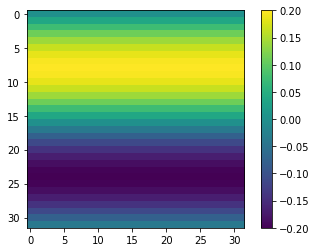

In [0]:
%pylab inline

plt.imshow(tf.transpose(out[5][0,0]))
plt.colorbar()